# Introduction

In this notebook, I want to reproduce (and more importantly, annotate) what Austin Rochford did in his [Bayesian Survival Analysis](https://austinrochford.com/posts/2015-10-05-bayes-survival.html) notebook on his own blog.


## Setup

In this dataset, we will analyze breast cancer patients who have undergone masectomy.

In [47]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
from statsmodels import datasets
import seaborn as sns
import theano.tensor as T

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First off, we load in the dataset.

In [9]:
df = datasets.get_rdataset('mastectomy', 'HSAUR', cache=True).data
df.sample(5)

,time,event,metastized
25,50,True,yes
14,10,True,yes
5,101,False,no
42,217,False,yes
16,18,True,yes


Inspecting what it looks like, it should be:

- Each row is one patient.
- For each patient, we record:
    - Time elapsed since masectomy (`time` column)
    - Whether they have died (`event` column)
    - Whether a metastasis has occcurred (`metastasized` column)

In order to get the data into shape for computing, we will need to do some data preprocessing. 

- Convert `event` to 1/0, where `1` maps to `True`.
- Convert `metastasized` to 1/0, where `1` maps to `yes`.

In [10]:
df['event'] = df['event'].astype(int)
df['metastized'] = df['metastized'].replace('yes', 1).replace('no', 0).astype(int)
df.head(5)

,time,event,metastized
0,23,1,0
1,47,1,0
2,69,1,0
3,70,0,0
4,100,0,0


From Austin's blog post:

> A suitable prior on ${\lambda}_{0}(t)$ is less obvious. We choose a semiparametric prior, where ${\lambda}_{0}(t)$ is a piecewise constant function. This prior requires us to partition the time range in question into intervals with endpoints $0≤s_{1}<s_{2}<⋯<s_{N}$. With this partition, ${\lambda}_{0}(t)={\lambda}_{j}$ if $s_{j}≤t<s_{j}+1$. With ${\lambda}_{0}(t)$ constrained to have this form, all we need to do is choose priors for the $N−1$ values ${\lambda}_{j}$. We use independent vague priors ${\lambda}_{j}\sim Gamma(10^{−2},10^{2})$. For our mastectomy example, we make each interval three months long.

In [13]:
interval_length = 3
interval_bounds = np.arange(0, df.time.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)
intervals

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75])

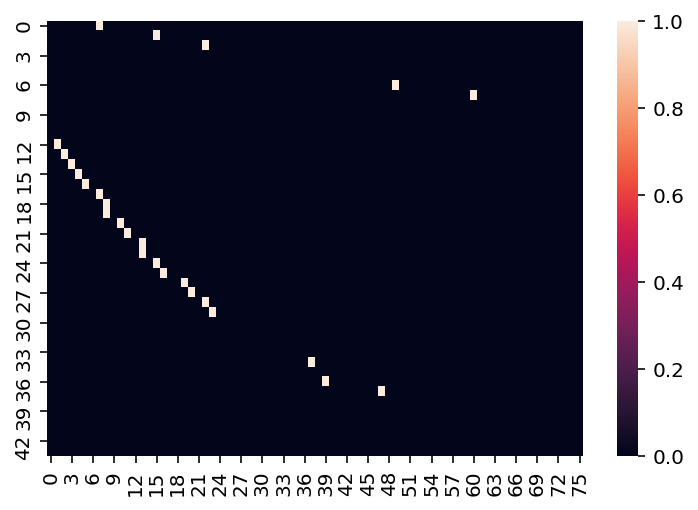

In [33]:
n_patients = len(df)
patients = np.arange(n_patients)

last_period = np.floor((df.time - 0.01) / interval_length)

death = np.zeros((n_patients, n_intervals))
death[patients.astype(int), last_period.values.astype(int)] = df.event.values
sns.heatmap(death)

Aha! This matrix tells us which patients have died and when. Each row is one patient, each column is a time period, and a `1` (white) indicates that a patient died in that time period.

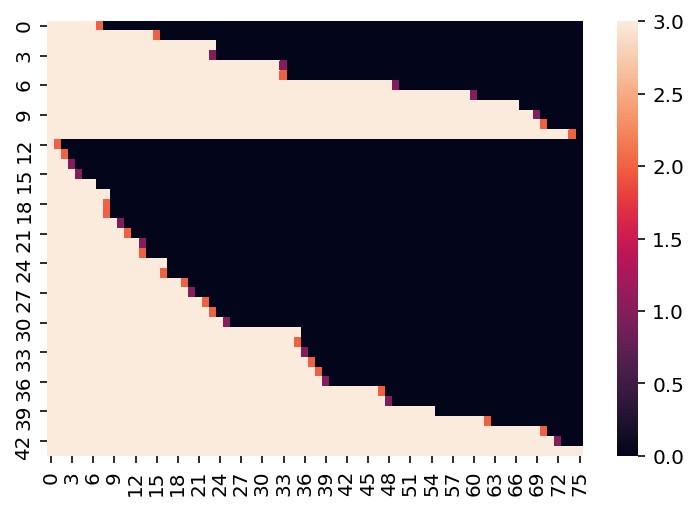

In [45]:
exposure = np.greater_equal.outer(df.time.values, interval_bounds[:-1]) * interval_length
exposure[patients, last_period.values.astype(int)] = df.time - interval_bounds[last_period.values.astype(int)]
sns.heatmap(exposure)

This heatmap tells us the time of exposure of a patient. Exposure is defined by whether they are exposed to a risk of dying or not. A patient is at risk of exposure if they have not died, up till the time they die (the non-censored patients) or the time that they have survived (the censored patients).

In [48]:
with pm.Model() as model:
    lambda0 = pm.Gamma('lambda0', 0.01, 0.01, shape=n_intervals)
    
    sigma = pm.Uniform('sigma', 0., 10.)
    tau = pm.Deterministic('tau', sigma**-2)
    mu_beta = pm.Normal('mu_beta', 0., 10**-2)
    beta = pm.Normal('beta', mu_beta, tau)
    
    lambda_ = pm.Deterministic('lambda_', T.outer(T.exp(beta * df.metastized), lambda0))
    mu = pm.Deterministic('mu', exposure * lambda_)
    
    obs = pm.Poisson('obs', mu, observed=death)

In [50]:
with model:
    trace = pm.sample(2000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, mu_beta, sigma_interval__, lambda0_log__]
100%|██████████| 2500/2500 [05:36<00:00,  7.44it/s]
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
There were 465 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c59d61208>,
      dtype=object)

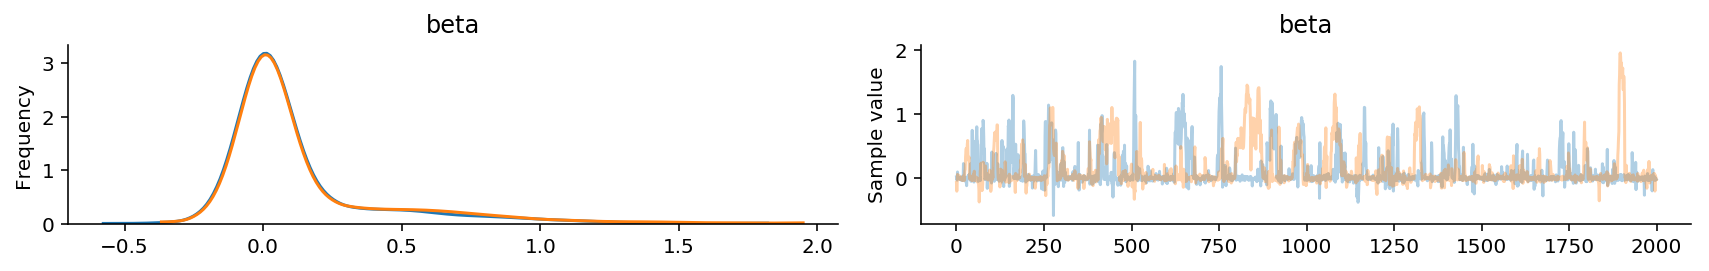

In [52]:
pm.traceplot(trace, varnames=['beta'])

In [65]:
base_hazard = trace['lambda0']
met_hazard = trace['lambda0'] * np.exp(np.atleast_2d(trace['beta']).T)

In [66]:
def cum_hazard(hazard):
    """
    Cumulative hazard is the cumulative sum of the 
    interval length * hazard at each time interval.
    """
    return (interval_length * hazard).cumsum(axis=-1)


def survival(hazard):
    """
    Survival is the exponent of the negative cumulative hazard.
    """
    return np.exp(-cum_hazard(hazard))

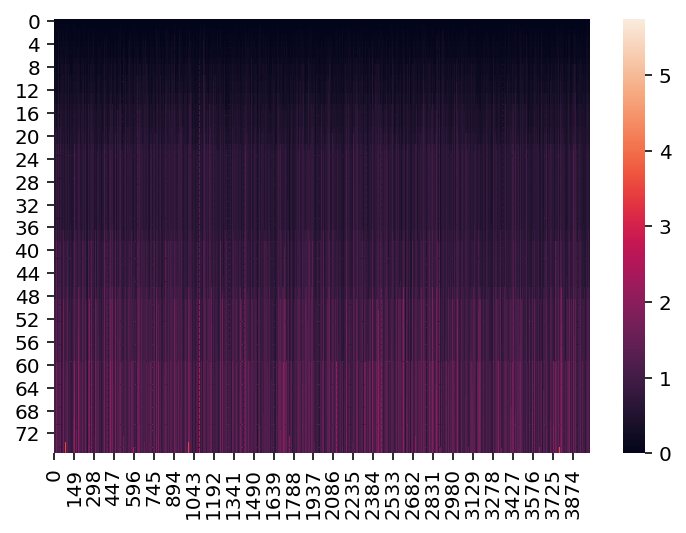

In [80]:
sns.heatmap(cum_hazard(met_hazard).T)

In [82]:
with pm.Model() as time_varying_model:
    lambda0 = pm.Gamma('lambda0', 0.01, 0.01, shape=n_intervals)
    
    # The key is here: if we want a parameter to vary with time, then making it follow a 
    # Gaussian random walk is one way of doing so.
    beta = pm.GaussianRandomWalk('beta', tau=1., shape=n_intervals)
    
    lambda_ = pm.Deterministic('h', lambda0 * T.exp(T.outer(T.constant(df.metastized), beta)))
    mu = pm.Deterministic('mu', exposure * lambda_)
    
    obs = pm.Poisson('obs', mu, observed=death)

In [83]:
with time_varying_model:
    trace_varying = pm.sample(2000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, lambda0_log__]
100%|██████████| 2500/2500 [10:23<00:00,  4.01it/s]
There were 233 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 469 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


NUTS sampling of both of these models has been really slow. I'm not quite sure how to debug this.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c6d8c1f28>,
      dtype=object)

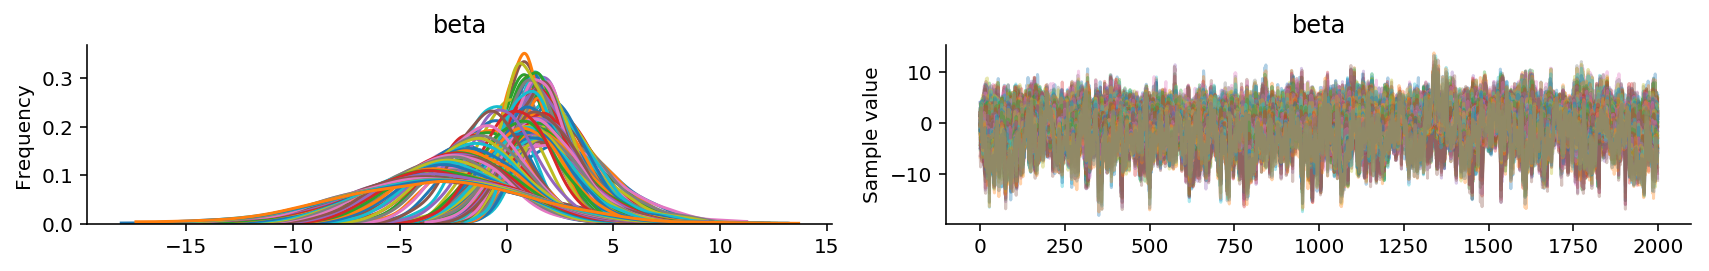

In [84]:
pm.traceplot(trace_varying, varnames=['beta'])

In [85]:
trace_varying['beta'].shape

(4000, 76)

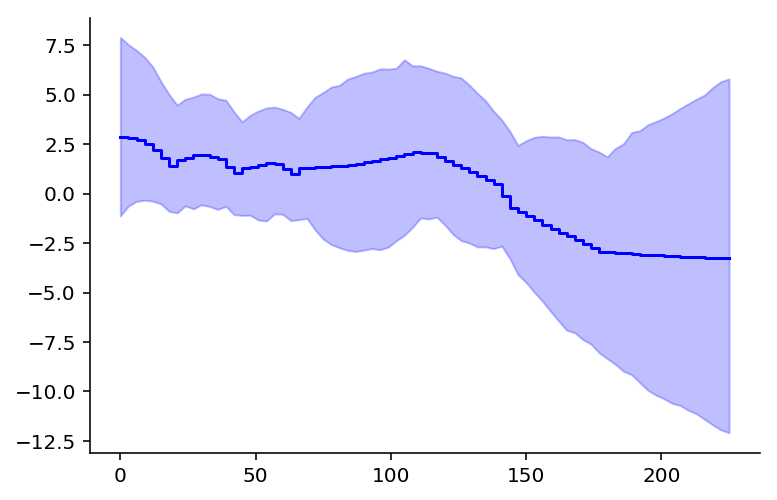

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111)

beta_hpd = np.percentile(trace_varying['beta'], [2.5, 97.5], axis=0)
beta_low = beta_hpd[0]
beta_high = beta_hpd[1]
ax.fill_between(interval_bounds[:-1], beta_low, beta_high,
                color='blue', alpha=0.25);
beta_hat = trace_varying['beta'].mean(axis=0)
ax.step(interval_bounds[:-1], beta_hat, color='blue')